# MSC_DA_CA1_Semester_2:
# A Comparative Study of VGG16 and EfficientNet for Potato Leaf Disease Detection: An Integration of Hadoop and Apache Spark

**Name:**
Madina Sagatova

**Student ID:**
2021255

**Student email:**
2021255@student.cct.ie

**Programme Title:**
MSc in Data Analytics

### Loading Image Dataset with PySpark

In [1]:
from pyspark.sql import SparkSession

# Create a Spark session 
spark = SparkSession.builder \
       .appName('PotatoLeafDiseas') \
       .config('spark.executor.memory', '4g') \
       .config('spark.driver.memory', '4g') \
       .getOrCreate()
spark

24/10/04 14:20:32 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [2]:
# Loading the images from HDFS 
data = spark.read.format('image').load('hdfs://localhost:9000/user1/potato_disease/*').limit(700)

# Displaying schema to ensure the data is loaded correctly 
data.printSchema()

# Show some sample data
data.show()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)



+--------------------+
|               image|
+--------------------+
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
+--------------------+
only showing top 20 rows



In [3]:
data.cache()

DataFrame[image: struct<origin:string,height:int,width:int,nChannels:int,mode:int,data:binary>]

### Label & Preprocess Data 

In [4]:
from pyspark.sql.functions import regexp_extract, col

# Add a label column based on the 3 folder names: Potato___Early_blight, Potato___healthy, Potato___Late_blight
data = data.withColumn('label',regexp_extract(col('image.origin'), 'potato_disease/([^/]+)', 1))

# Show some labeled data
data.select('image.origin', 'label').show(15)

+--------------------+--------------------+
|              origin|               label|
+--------------------+--------------------+
|hdfs://localhost:...|Potato___Early_bl...|
|hdfs://localhost:...|Potato___Early_bl...|
|hdfs://localhost:...|    Potato___healthy|
|hdfs://localhost:...|    Potato___healthy|
|hdfs://localhost:...|    Potato___healthy|
|hdfs://localhost:...|Potato___Early_bl...|
|hdfs://localhost:...|    Potato___healthy|
|hdfs://localhost:...|    Potato___healthy|
|hdfs://localhost:...|Potato___Early_bl...|
|hdfs://localhost:...|    Potato___healthy|
|hdfs://localhost:...|    Potato___healthy|
|hdfs://localhost:...|    Potato___healthy|
|hdfs://localhost:...|Potato___Early_bl...|
|hdfs://localhost:...|Potato___Early_bl...|
|hdfs://localhost:...|    Potato___healthy|
+--------------------+--------------------+
only showing top 15 rows



### Display Original Images before Resizing 

In [5]:
#!pip install matplotlib

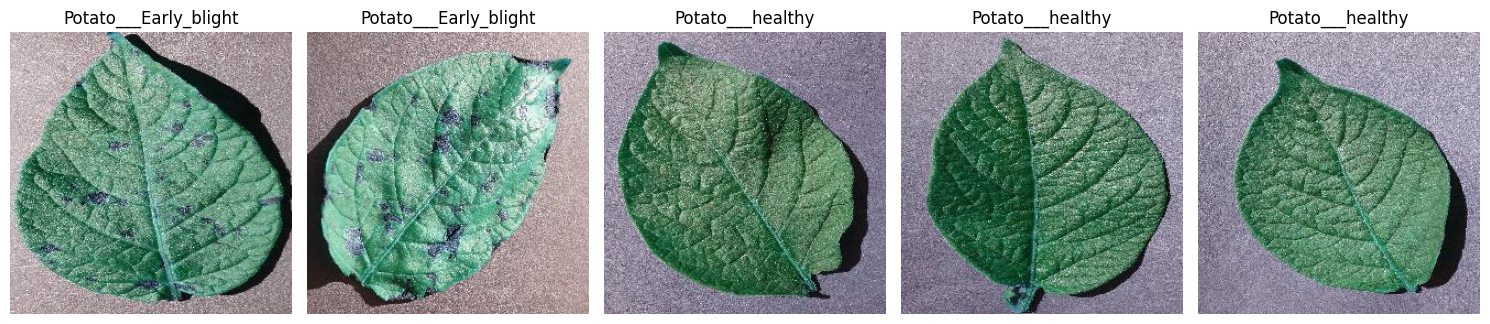

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Function to display an image - takes a list of img data and their corresponding titles
def display_images(image_data_list, heights, widths, nChannels, titles=None):
    plt.figure(figsize=(15,10)) # set fig size
    
    for i in range(len(image_data_list)):
        plt.subplot(1, len(image_data_list), i + 1) # create subplot for each img
        # convert binary image data to a numpy array
        image_array = np.frombuffer(image_data_list[i], np.uint8).reshape((heights[i],
                                                               widths[i],
                                                               nChannels
                                                               ))
        # Display the img
        plt.imshow(image_array)
        if titles:
            plt.title(titles[i]) # set the title if provided
        plt.axis('off') # hide axes
        
    plt.tight_layout() # adjust spacing between subplots
    plt.show()
    
# Sample of 5 rows from the DF
sample_images = data.take(5) # the first 5 rows

# List for img data, heights, widths and titles 
image_data_list = []
heights = []
widths = []
titles =[]

for row in sample_images:
    image_data_list.append(row['image']['data'])
    heights.append(row['image']['height'])
    widths.append(row['image']['width'])
    titles.append(row['label']) # display the label for the title 

    
# Display the img
display_images(image_data_list, heights, widths, sample_images[0]['image']['nChannels'], titles)


### Label Encoding 

In [7]:
from pyspark.ml.feature import StringIndexer

# Initialize StringIndexer to convert labels into numerical values
indexer = StringIndexer(inputCol='label', outputCol='labelIndex')

# Fit and Transform the DF
data = indexer.fit(data).transform(data)

# Show the data to verify label encoding 
data.select('label', 'labelIndex').show(5)

+--------------------+----------+
|               label|labelIndex|
+--------------------+----------+
|Potato___Early_bl...|       0.0|
|Potato___Early_bl...|       0.0|
|    Potato___healthy|       2.0|
|    Potato___healthy|       2.0|
|    Potato___healthy|       2.0|
+--------------------+----------+
only showing top 5 rows



### Image Resizing & Normalization 

In [8]:
# Import an OpenCV library
import cv2
# Import Row
from pyspark.sql import Row


# Function to convert the binary data into NumPy arrays, resize the imgs, and then normalize them
def resize_and_normalize_image(row, new_size=(224, 224)):
    # convert bynary data into a numpy array, use reshape it to the original dimensions
    image_data = np.frombuffer(row.image.data, dtype=np.uint8).reshape(
    (row.image.height, row.image.width, row.image.nChannels))
    # resize the image using OpenCV
    resized_image = cv2.resize(image_data, new_size)

    # normalize the pixels to the range - [0, 1]
    normalized_image = resized_image.astype('float32') / 255.0
    return normalized_image.tolist()

#Apply the function to resize & normalize all images
resized_normalized_rdd = data.rdd.map(lambda row: Row(image=resize_and_normalize_image(row), labelIndex=row.labelIndex))

resized_normalized_df = resized_normalized_rdd.toDF()

# Show the resized and normalized DF schema to verufy the changes
resized_normalized_df.printSchema()
resized_normalized_df.show()

root
 |-- image: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: array (containsNull = true)
 |    |    |    |-- element: double (containsNull = true)
 |-- labelIndex: double (nullable = true)



24/10/04 14:22:43 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 12 (TID 74): Attempting to kill Python Worker


+--------------------+----------+
|               image|labelIndex|
+--------------------+----------+
|[[[0.729411780834...|       0.0|
|[[[0.564705908298...|       0.0|
|[[[0.541176497936...|       2.0|
|[[[0.588235318660...|       2.0|
|[[[0.607843160629...|       2.0|
|[[[0.725490212440...|       0.0|
|[[[0.725490212440...|       2.0|
|[[[0.576470613479...|       2.0|
|[[[0.454901963472...|       0.0|
|[[[0.568627476692...|       2.0|
|[[[0.682352960109...|       2.0|
|[[[0.462745100259...|       2.0|
|[[[0.792156875133...|       0.0|
|[[[0.517647087574...|       0.0|
|[[[0.509803950786...|       2.0|
|[[[0.709803938865...|       2.0|
|[[[0.776470601558...|       0.0|
|[[[0.815686285495...|       0.0|
|[[[0.596078455448...|       2.0|
|[[[0.678431391716...|       0.0|
+--------------------+----------+
only showing top 20 rows



In [9]:
data.unpersist()

DataFrame[image: struct<origin:string,height:int,width:int,nChannels:int,mode:int,data:binary>, label: string, labelIndex: double]

### Split the Data

In [10]:
# Split the dataset into testing and training sets
training_data, testing_data = resized_normalized_df.randomSplit([0.8, 0.2], seed=42)

# Print the sets sizes
print('Training set size: ', training_data.count())
print('Testing set size: ', testing_data.count())

Training set size:  588


Testing set size:  112


### Convert PySpark DF to NymPy arrays

In [11]:
def train_generator():
    for row in training_data.toLocalIteratorL():
        yield np.array(row['image'], dtype=np.float32), row['labelIndex']

        
def test_generator():
    for row in testing_data.toLocalIteratorL():
        yield np.array(row['image'], dtype=np.float32), row['labelIndex']

        

In [12]:
import tensorflow as tf
train_dataset = tf.data.Dataset.from_generator(
    train_generator,
    output_signature=(
        tf.TensorSpec(shape=(224,224,3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
).batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_generator(
    test_generator,
    output_signature=(
        tf.TensorSpec(shape=(224,224,3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
).batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

2024-10-04 14:25:09.460890: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-04 14:25:09.882330: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-04 14:25:10.246222: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-04 14:25:10.524798: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-04 14:25:10.613856: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-04 14:25:11.180277: I tensorflow/core/platform/cpu_feature_gu

### Load and Fine-tune VGG16 Model

In [13]:
#!pip install scikit-learn

In [14]:
#!pip install seaborn

In [15]:
# import libraries 
from tensorflow.keras.applications import VGG16, EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [16]:
# clear the session 
tf.keras.backend.clear_session()

# Loading VGG16 model with Pre-trained Weights - without final (top) layer
base_model = VGG16(weights='imagenet', 
                   include_top=False,
                   input_shape=(224, 224, 3))

In [17]:
#Freeze the layers of the base model, -> only final layer learns from new dataset
for layer in base_model.layers:
    layer.trainable = False

In [18]:
num_classes = len(training_data.select('labelIndex').distinct().collect())
print('Number of classes:', num_classes)

Number of classes: 3


In [19]:
# Fine-tune the model 
model_vgg = Sequential()
model_vgg.add(base_model)
#model_vgg.add(Flatten())
#model_vgg.add(Dense(512, activation='relu'))
#model_vgg.add(Dropout(0.5))
#model_vgg.add(Dense(num_classes, activation='softmax'))

model_vgg.add(GlobalAveragePooling2D())
model_vgg.add(Flatten())
model_vgg.add(Dense(256, activation='relu'))
model_vgg.add(Dropout(0.5))
model_vgg.add(Dense(256, activation='relu'))        
model_vgg.add(Dropout(0.5))
model_vgg.add(Dense(num_classes, activation='softmax'))

model_vgg.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,912,579 (56.89 MB)

 Trainable params: 197,891 (773.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [20]:
#!pip install pydot

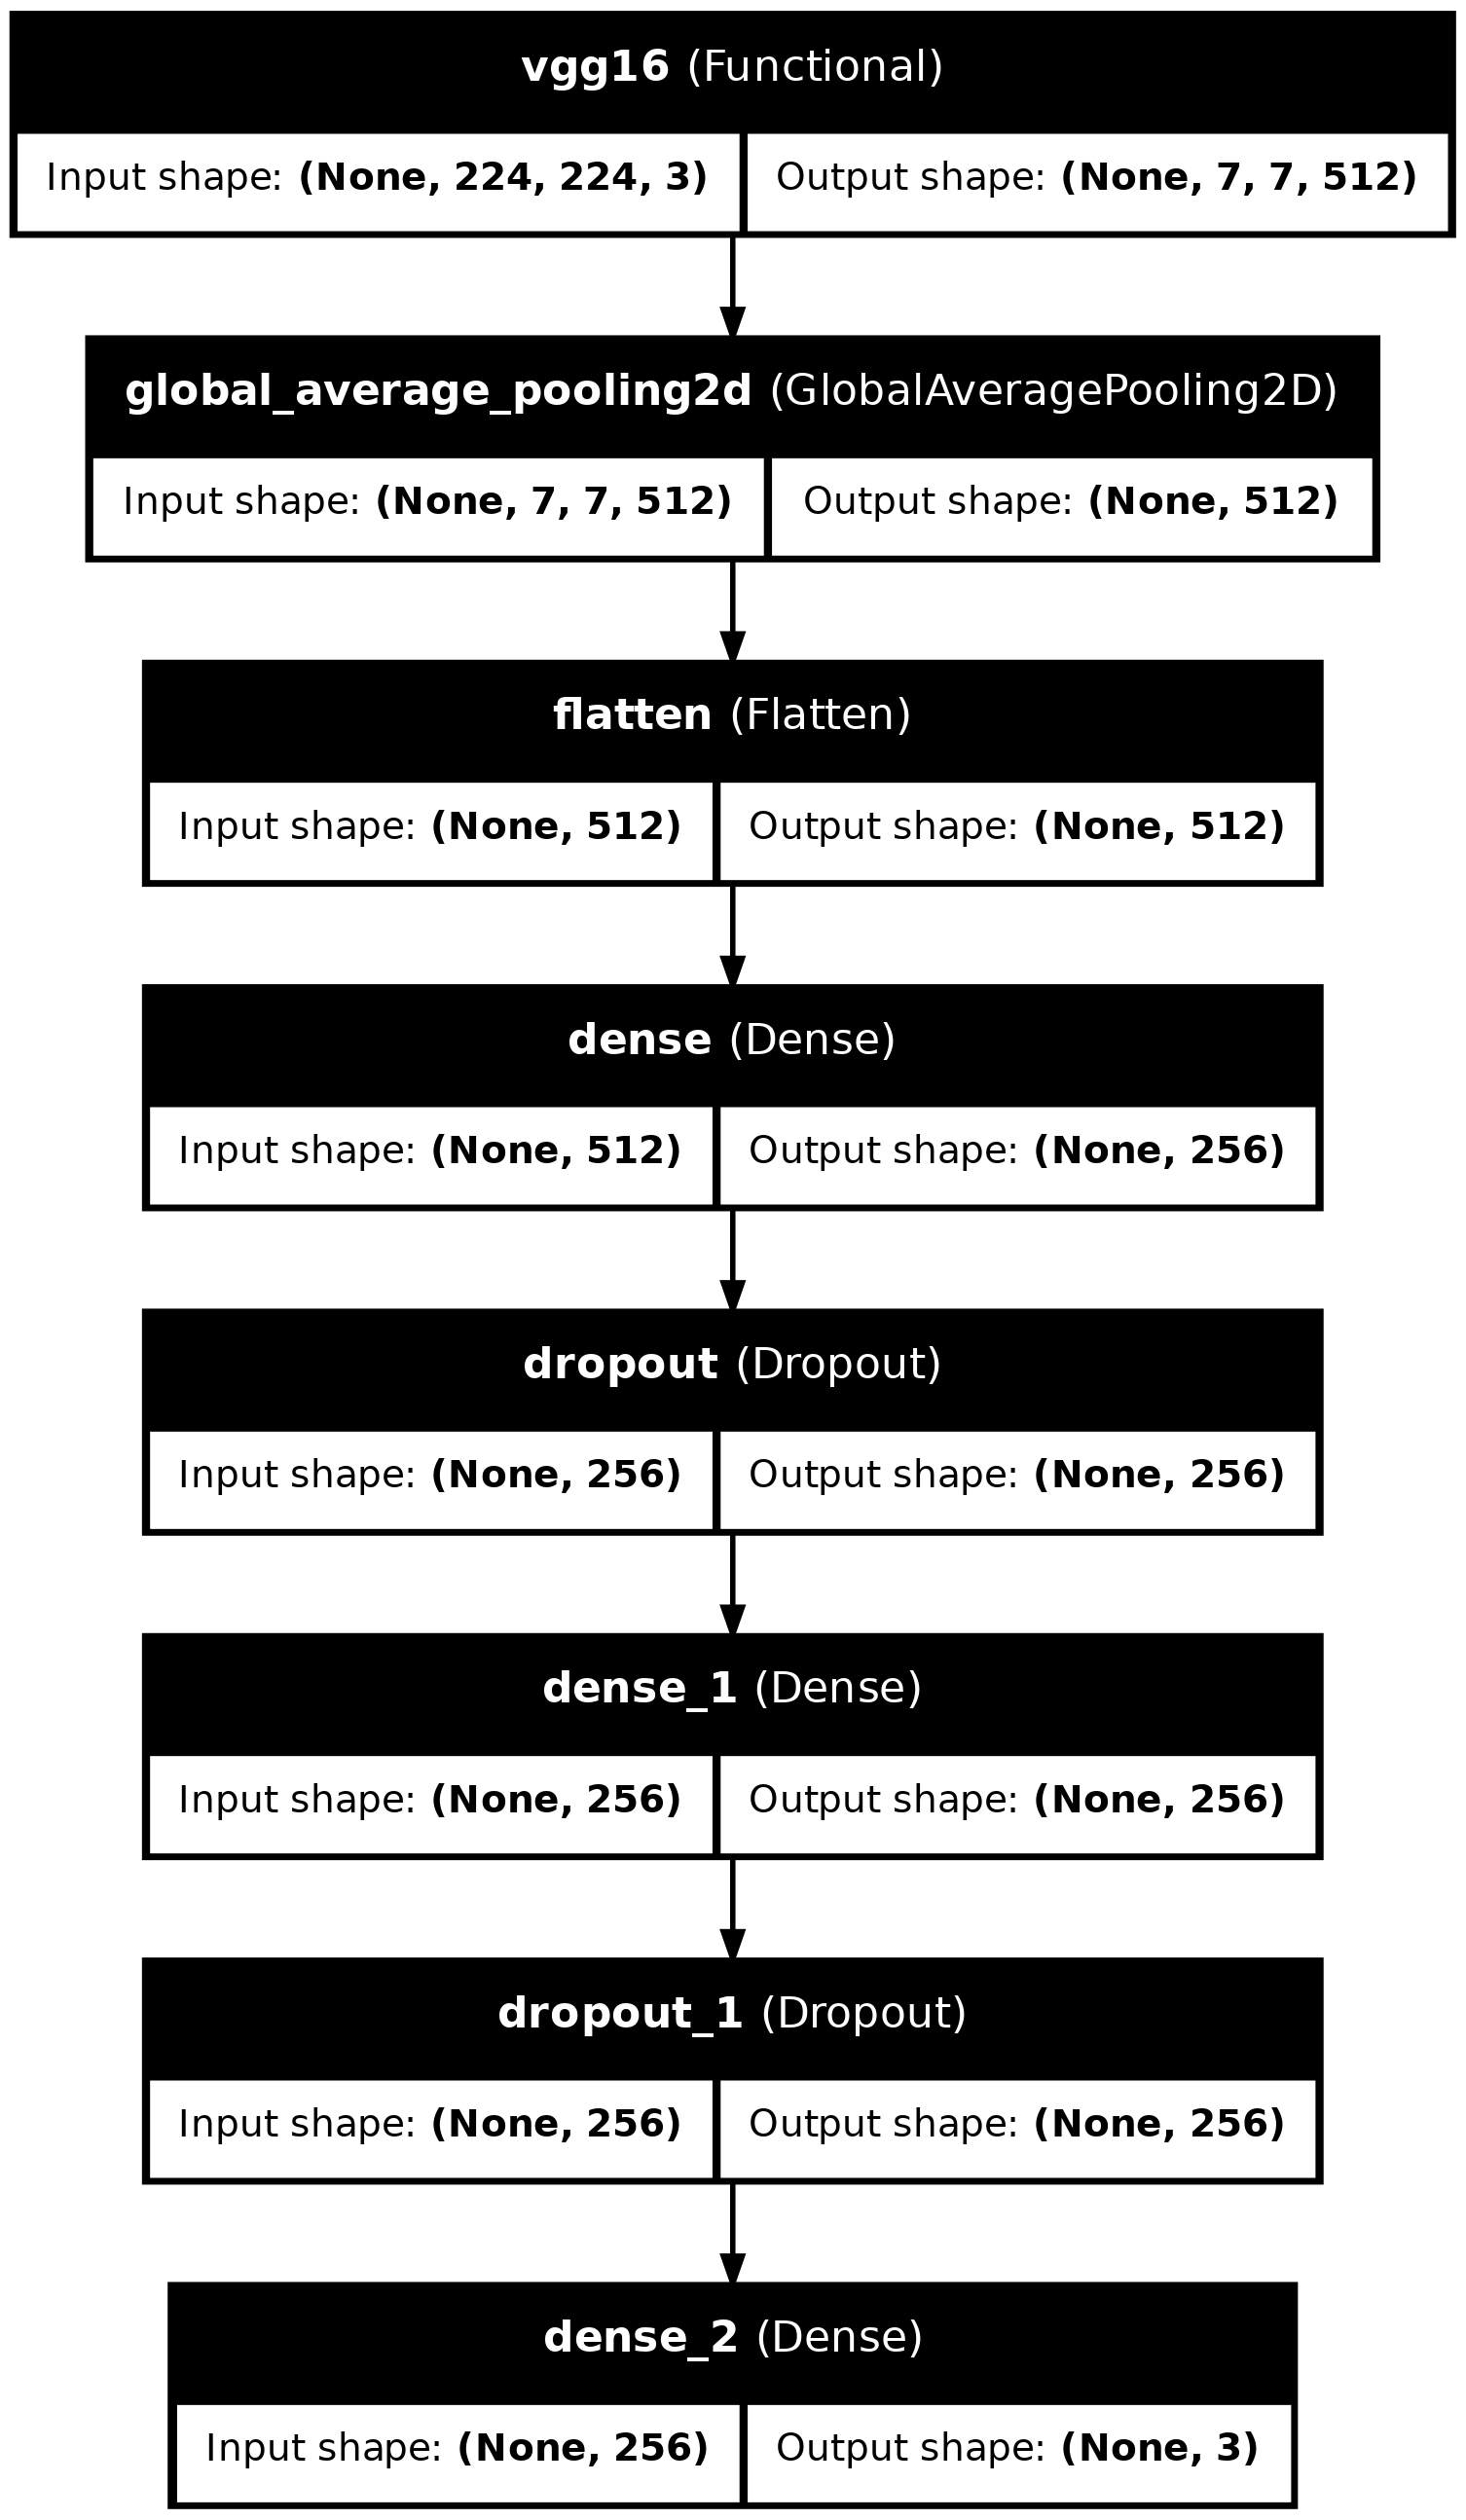

In [21]:
tf.keras.utils.plot_model(model_vgg, to_file="vgg16_image_classifier.png", 
                          show_shapes=True,
                          show_layer_names=True)

In [ ]:
# Compile the model
model_vgg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='SparseCategoricalCrossentropy',
                  metrics=['accuracy'])